In [75]:
import gym
import tensorflow as tf
from collections import deque
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from gym import wrappers

In [89]:
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env,'./monitor')

[2017-07-14 00:55:20,334] Making new env: FrozenLake-v0


In [90]:
print(env.observation_space.n)
print(env.action_space.n)

16
4


In [73]:
state = env.reset()
for i in range(10):
    #env.render()
    action = env.action_space.sample()
    next_state, reward, done, prob = env.step(action)
    print('state:{} action:{} next_state:{} reward:{} done:{}'.format(state, action, next_state, reward, done))
    state = next_state
    if done:
        break

[2017-07-14 00:49:00,388] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\openaigym.video.0.12536.video000000.json


state:0 action:0 next_state:0 reward:0.0 done:False
state:0 action:3 next_state:0 reward:0.0 done:False
state:0 action:0 next_state:0 reward:0.0 done:False
state:0 action:1 next_state:0 reward:0.0 done:False
state:0 action:2 next_state:0 reward:0.0 done:False
state:0 action:0 next_state:0 reward:0.0 done:False
state:0 action:3 next_state:0 reward:0.0 done:False
state:0 action:2 next_state:1 reward:0.0 done:False
state:1 action:1 next_state:0 reward:0.0 done:False
state:0 action:3 next_state:0 reward:0.0 done:False


In [91]:
learning_rate = 0.001
memory_size = 2000

episodes = 1000
steps = 100
gamma = 0.99

epsilon = 1
epsilon_stop = 0.01
epsilon_decay = 0.99
batch_size = 32

In [92]:
bot = Sequential()
bot.add(Dense(10, input_dim=16, activation='relu'))
bot.add(Dense(4, activation='linear'))
bot.compile(loss='mse', optimizer = Adam(learning_rate))
memory = deque(maxlen=memory_size)

In [93]:
state_lkup = np.eye(env.observation_space.n)
action_lkup = np.eye(env.action_space.n)

In [94]:
reward_list=[]
state = env.reset()
for episode in range(episodes):
    total_reward = 0
    state = env.reset()
    for step in range(steps):
        if epsilon > np.random.rand():
            action = env.action_space.sample()
        else:
            action = np.argmax(bot.predict(np.reshape(state_lkup[state], (-1, env.observation_space.n))))
        next_state, reward, done, prob = env.step(action)
        if done and reward==0:
            reward = -1
        if not done and reward==0:
            reward = -0.02
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward = total_reward + reward
        if done:
            print('episode:{} steps:{} total reward:{} epsilon:{}'.format(episode + 1, step + 1, total_reward, epsilon))
            reward_list.append(total_reward)
            break
    minibatch = [memory[ii] for ii in np.random.choice(len(memory), batch_size)]
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target = reward + gamma * np.amax(bot.predict(np.reshape(state_lkup[next_state], (-1, env.observation_space.n))), axis = 1)
        targetQ = bot.predict(np.reshape(state_lkup[state], (-1, env.observation_space.n)))
        targetQ[0][action] = target
        bot.fit(np.reshape(state_lkup[state], (-1, env.observation_space.n)), targetQ, epochs=1, verbose=0)
    if epsilon > epsilon_stop:
        epsilon = epsilon * epsilon_decay

[2017-07-14 00:55:39,525] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video000000.json
[2017-07-14 00:55:39,534] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video000001.json


episode:1 steps:8 total reward:-1.1400000000000001 epsilon:1
episode:2 steps:12 total reward:-1.22 epsilon:0.99
episode:3 steps:2 total reward:-1.02 epsilon:0.9801
episode:4 steps:8 total reward:-1.1400000000000001 epsilon:0.9702989999999999
episode:5 steps:9 total reward:-1.16 epsilon:0.96059601
episode:6 steps:17 total reward:-1.32 epsilon:0.9509900498999999
episode:7 steps:4 total reward:-1.06 epsilon:0.9414801494009999


[2017-07-14 00:55:42,796] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video000008.json


episode:8 steps:8 total reward:-1.1400000000000001 epsilon:0.9320653479069899
episode:9 steps:3 total reward:-1.04 epsilon:0.92274469442792
episode:10 steps:4 total reward:-1.06 epsilon:0.9135172474836407
episode:11 steps:6 total reward:-1.1 epsilon:0.9043820750088043
episode:12 steps:2 total reward:-1.02 epsilon:0.8953382542587163
episode:13 steps:8 total reward:-1.1400000000000001 epsilon:0.8863848717161291
episode:14 steps:18 total reward:-1.34 epsilon:0.8775210229989678
episode:15 steps:3 total reward:-1.04 epsilon:0.8687458127689781
episode:16 steps:3 total reward:-1.04 epsilon:0.8600583546412883
episode:17 steps:2 total reward:-1.02 epsilon:0.8514577710948754
episode:18 steps:3 total reward:-1.04 epsilon:0.8429431933839266
episode:19 steps:4 total reward:-1.06 epsilon:0.8345137614500874
episode:20 steps:28 total reward:-1.54 epsilon:0.8261686238355865
episode:21 steps:3 total reward:-1.04 epsilon:0.8179069375972307
episode:22 steps:3 total reward:-1.04 epsilon:0.8097278682212583


[2017-07-14 00:55:46,141] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video000027.json


episode:27 steps:10 total reward:-1.18 epsilon:0.7700431458051551
episode:28 steps:6 total reward:-1.1 epsilon:0.7623427143471035
episode:29 steps:7 total reward:-1.12 epsilon:0.7547192872036325
episode:30 steps:5 total reward:-1.08 epsilon:0.7471720943315961
episode:31 steps:3 total reward:-1.04 epsilon:0.7397003733882802
episode:32 steps:4 total reward:-1.06 epsilon:0.7323033696543974
episode:33 steps:5 total reward:-1.08 epsilon:0.7249803359578534
episode:34 steps:8 total reward:-1.1400000000000001 epsilon:0.7177305325982748
episode:35 steps:29 total reward:-1.56 epsilon:0.7105532272722921
episode:36 steps:4 total reward:-1.06 epsilon:0.7034476949995692
episode:37 steps:3 total reward:-1.04 epsilon:0.6964132180495735
episode:38 steps:15 total reward:-1.28 epsilon:0.6894490858690777
episode:39 steps:6 total reward:-1.1 epsilon:0.682554595010387
episode:40 steps:4 total reward:-1.06 epsilon:0.6757290490602831
episode:41 steps:3 total reward:-1.04 epsilon:0.6689717585696803
episode:42 

[2017-07-14 00:55:52,884] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video000064.json


episode:64 steps:4 total reward:-1.06 epsilon:0.5309055429551132
episode:65 steps:20 total reward:-1.3800000000000001 epsilon:0.525596487525562
episode:66 steps:17 total reward:-1.32 epsilon:0.5203405226503064
episode:67 steps:6 total reward:-1.1 epsilon:0.5151371174238033
episode:68 steps:7 total reward:-1.12 epsilon:0.5099857462495653
episode:69 steps:39 total reward:-1.7600000000000002 epsilon:0.5048858887870696
episode:70 steps:12 total reward:-1.22 epsilon:0.4998370298991989
episode:71 steps:14 total reward:-1.26 epsilon:0.49483865960020695
episode:72 steps:32 total reward:-1.62 epsilon:0.4898902730042049
episode:73 steps:25 total reward:-1.4800000000000002 epsilon:0.48499137027416284
episode:74 steps:5 total reward:-1.08 epsilon:0.4801414565714212
episode:75 steps:31 total reward:-1.6 epsilon:0.475340042005707
episode:76 steps:10 total reward:-1.18 epsilon:0.47058664158564995
episode:77 steps:6 total reward:-1.1 epsilon:0.4658807751697934
episode:78 steps:14 total reward:-1.26 ep

[2017-07-14 00:56:06,290] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video000125.json


episode:125 steps:6 total reward:-1.1 epsilon:0.28758360936686406
episode:126 steps:9 total reward:-1.16 epsilon:0.2847077732731954
episode:127 steps:13 total reward:-1.24 epsilon:0.28186069554046345
episode:128 steps:8 total reward:0.86 epsilon:0.2790420885850588
episode:129 steps:13 total reward:-1.24 epsilon:0.2762516676992082
episode:130 steps:4 total reward:-1.06 epsilon:0.27348915102221616
episode:131 steps:2 total reward:-1.02 epsilon:0.270754259511994
episode:132 steps:5 total reward:-1.08 epsilon:0.26804671691687404
episode:133 steps:7 total reward:-1.12 epsilon:0.2653662497477053
episode:134 steps:2 total reward:-1.02 epsilon:0.2627125872502282
episode:135 steps:4 total reward:-1.06 epsilon:0.2600854613777259
episode:136 steps:2 total reward:-1.02 epsilon:0.2574846067639487
episode:137 steps:5 total reward:-1.08 epsilon:0.2549097606963092
episode:138 steps:12 total reward:-1.22 epsilon:0.2523606630893461
episode:139 steps:11 total reward:0.8 epsilon:0.24983705645845267
episod

[2017-07-14 00:56:26,032] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video000216.json


episode:215 steps:11 total reward:-1.2 epsilon:0.11639428152900344
episode:216 steps:16 total reward:-1.3 epsilon:0.11523033871371341
episode:217 steps:23 total reward:0.5599999999999998 epsilon:0.11407803532657627
episode:218 steps:5 total reward:-1.08 epsilon:0.11293725497331052
episode:219 steps:2 total reward:-1.02 epsilon:0.1118078824235774
episode:220 steps:15 total reward:-1.28 epsilon:0.11068980359934164
episode:221 steps:6 total reward:-1.1 epsilon:0.10958290556334822
episode:222 steps:24 total reward:-1.4600000000000002 epsilon:0.10848707650771475
episode:223 steps:23 total reward:0.5599999999999998 epsilon:0.1074022057426376
episode:224 steps:39 total reward:-1.7600000000000002 epsilon:0.10632818368521123
episode:225 steps:44 total reward:-1.8600000000000003 epsilon:0.10526490184835911
episode:226 steps:12 total reward:0.78 epsilon:0.10421225282987552
episode:227 steps:15 total reward:0.72 epsilon:0.10317013030157676
episode:228 steps:17 total reward:0.6799999999999999 epsil

[2017-07-14 01:03:01,880] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video000343.json


episode:343 steps:10 total reward:-1.18 epsilon:0.032154114383038335
episode:344 steps:29 total reward:-1.56 epsilon:0.03183257323920795
episode:345 steps:18 total reward:-1.34 epsilon:0.03151424750681587
episode:346 steps:13 total reward:-1.24 epsilon:0.03119910503174771
episode:347 steps:10 total reward:0.8200000000000001 epsilon:0.030887113981430233
episode:348 steps:26 total reward:-1.5 epsilon:0.03057824284161593
episode:349 steps:95 total reward:-0.8800000000000012 epsilon:0.03027246041319977
episode:350 steps:21 total reward:0.5999999999999999 epsilon:0.029969735809067772
episode:351 steps:85 total reward:-0.680000000000001 epsilon:0.029670038450977095
episode:352 steps:57 total reward:-2.1200000000000006 epsilon:0.029373338066467324
episode:353 steps:60 total reward:-2.1800000000000006 epsilon:0.02907960468580265
episode:354 steps:25 total reward:0.5199999999999998 epsilon:0.028788808638944622
episode:355 steps:6 total reward:-1.1 epsilon:0.028500920552555174
episode:356 steps:

[2017-07-14 01:03:39,931] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video000512.json


episode:512 steps:21 total reward:0.5999999999999999 epsilon:0.009920974201040588
episode:513 steps:31 total reward:-1.6 epsilon:0.009920974201040588
episode:514 steps:31 total reward:-1.6 epsilon:0.009920974201040588
episode:515 steps:63 total reward:-2.2400000000000007 epsilon:0.009920974201040588
episode:516 steps:98 total reward:-0.9400000000000013 epsilon:0.009920974201040588
episode:517 steps:47 total reward:-1.9200000000000004 epsilon:0.009920974201040588
episode:518 steps:6 total reward:-1.1 epsilon:0.009920974201040588
episode:519 steps:26 total reward:0.4999999999999999 epsilon:0.009920974201040588
episode:520 steps:54 total reward:-2.0600000000000005 epsilon:0.009920974201040588
episode:521 steps:27 total reward:0.47999999999999987 epsilon:0.009920974201040588
episode:522 steps:38 total reward:-1.7400000000000002 epsilon:0.009920974201040588
episode:523 steps:35 total reward:0.31999999999999973 epsilon:0.009920974201040588
episode:524 steps:29 total reward:0.4399999999999998

[2017-07-14 01:04:24,991] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video000729.json


episode:729 steps:55 total reward:-2.0800000000000005 epsilon:0.009920974201040588
episode:730 steps:83 total reward:-2.640000000000001 epsilon:0.009920974201040588
episode:731 steps:12 total reward:0.78 epsilon:0.009920974201040588
episode:732 steps:8 total reward:-1.1400000000000001 epsilon:0.009920974201040588
episode:733 steps:35 total reward:-1.6800000000000002 epsilon:0.009920974201040588
episode:734 steps:41 total reward:0.19999999999999962 epsilon:0.009920974201040588
episode:735 steps:52 total reward:-0.020000000000000462 epsilon:0.009920974201040588
episode:736 steps:89 total reward:-0.7600000000000011 epsilon:0.009920974201040588
episode:737 steps:24 total reward:0.5399999999999998 epsilon:0.009920974201040588
episode:738 steps:36 total reward:-1.7000000000000002 epsilon:0.009920974201040588
episode:739 steps:60 total reward:-2.1800000000000006 epsilon:0.009920974201040588
episode:740 steps:20 total reward:-1.3800000000000001 epsilon:0.009920974201040588
episode:741 steps:16

[2017-07-14 01:05:17,076] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.12536.video001000.json


episode:1000 steps:12 total reward:-1.22 epsilon:0.009920974201040588


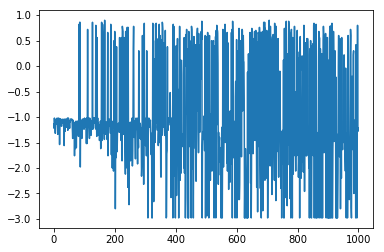

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(reward_list)

In [97]:
env.close()
gym.upload('./monitor', api_key='sk_zKABSY1QRuWa3r7GHTxPeQ')

[2017-07-14 01:08:51,255] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\abjilani\\Desktop\\Projects\\DL Nanodegree\\my-experiments\\reinforcement learning\\monitor')
[2017-07-14 01:08:51,259] [FrozenLake-v0] Uploading 1000 episodes of training data
[2017-07-14 01:08:55,921] [FrozenLake-v0] Uploading videos of 11 training episodes (1369 bytes)
[2017-07-14 01:08:56,758] [FrozenLake-v0] Creating evaluation object from ./monitor with learning curve and training video
[2017-07-14 01:08:57,371] 
****************************************************
You successfully uploaded your evaluation on FrozenLake-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_6MfqkVgpQgC2Cu22lu4Iw

****************************************************
